In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

## Read the data

In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

## Analyse the data

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

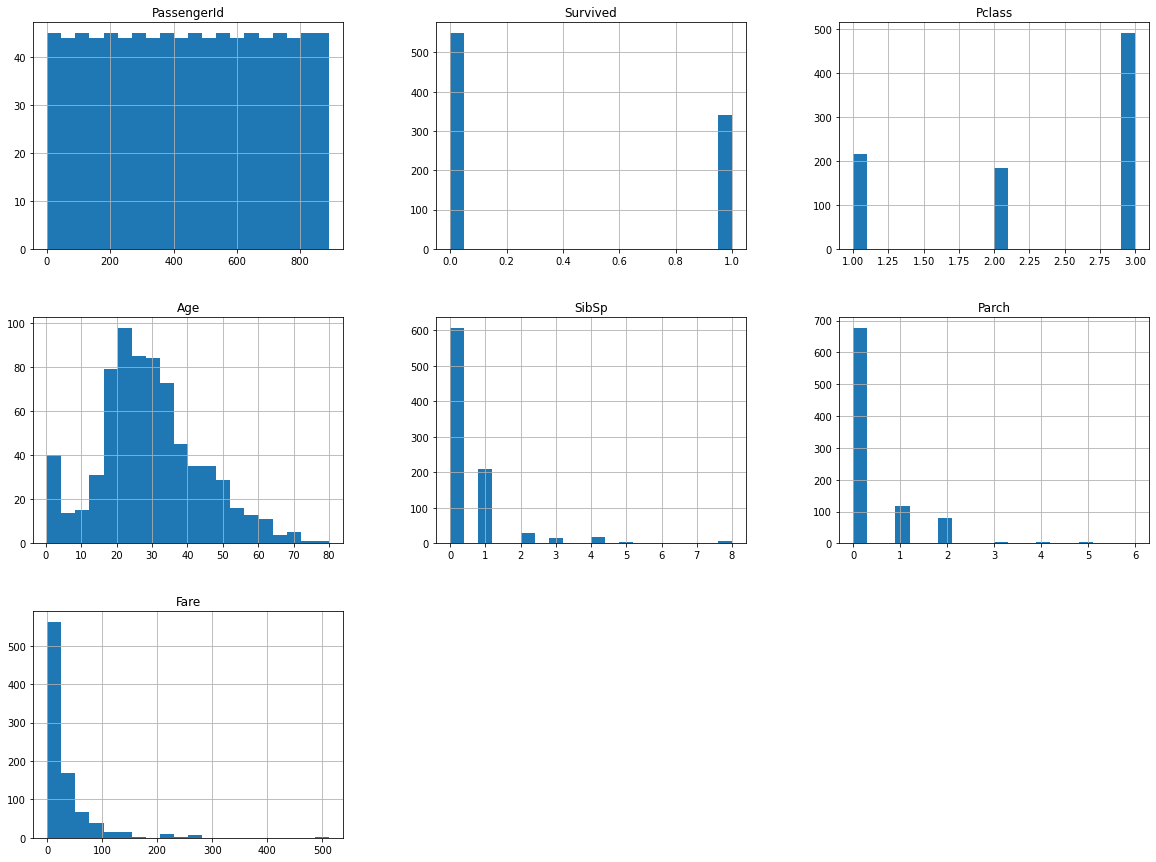

In [6]:
train_df.hist(bins=20, figsize=(20,15))

#### Numerical attributes

**Pclass**

In [7]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"]).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Passengers from first class were more likely to survive, so it is okay to leave this attribute as it is. 

**Age**

Age should be divided into buckets

In [8]:
pd.cut(train_df['Age'], bins=6).value_counts()

(13.683, 26.947]    248
(26.947, 40.21]     245
(40.21, 53.473]     100
(0.34, 13.683]       71
(53.473, 66.737]     43
(66.737, 80.0]        7
Name: Age, dtype: int64

**SibSp and Parch**

I will make one attribute from sum of Patch and SibSp

In [9]:
train_df["RelativesOnboard"] = train_df["SibSp"] + train_df["Parch"]
test_df["RelativesOnboard"] = test_df["SibSp"] + test_df["Parch"]

**Fare**

Fare will be divided into buckets as well

In [10]:
pd.cut(train_df['Fare'], bins=20).value_counts()

(-0.512, 25.616]      562
(25.616, 51.233]      170
(51.233, 76.849]       67
(76.849, 102.466]      39
(128.082, 153.699]     16
(102.466, 128.082]     15
(204.932, 230.548]      9
(256.165, 281.781]      6
(486.713, 512.329]      3
(230.548, 256.165]      2
(153.699, 179.315]      2
(179.315, 204.932]      0
(281.781, 307.398]      0
(307.398, 333.014]      0
(333.014, 358.63]       0
(358.63, 384.247]       0
(384.247, 409.863]      0
(409.863, 435.48]       0
(435.48, 461.096]       0
(461.096, 486.713]      0
Name: Fare, dtype: int64

#### Categorical attributes

**Name** <br>
In my opinion this attribute will not be informative to the model, so leave it at the moment

In [11]:
train_df['Name'].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

**Sex**<br>
Change it to binary value

In [12]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

**Ticket**<br>
Leave at the moment

In [13]:
train_df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [14]:
train_df['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [15]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Look for correlations

In [16]:
corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived            1.000000
Fare                0.257307
Parch               0.081629
RelativesOnboard    0.016639
PassengerId        -0.005007
SibSp              -0.035322
Age                -0.077221
Pclass             -0.338481
Name: Survived, dtype: float64

## Make a pipeline

In [17]:
class FlatDiscretizer(TransformerMixin, BaseEstimator):
    def __init__(self, attr, n_bins=5, encode='onehot'):
        self.attr = attr
        self.discretizer = KBinsDiscretizer(n_bins=n_bins, encode=encode)
        
    def fit(self, X, y=None):
        self.discretizer.fit(X[self.attr].to_numpy().reshape(-1,1))
        return self
    
    def transform(self, X, y=None):
        new_X = self.discretizer.transform(X[self.attr].to_numpy().reshape(-1,1))
        return new_X.squeeze()

In [18]:
num_attribs = ['Age', 'Fare', 'Pclass']
cat_attribs = ['Sex', 'Embarked']

In [19]:
age_pipeline = Pipeline([
    ("age_imputer", SimpleImputer(strategy="median")),
    ("age_discretizer", FlatDiscretizer(attr="Age", n_bins=6, encode='ordinal'))
])

In [20]:
fare_pipeline = Pipeline([
    ("fare_discretizer", FlatDiscretizer(attr="Fare", n_bins=20, encode='ordinal'))
])

In [21]:
num_pipeline = Pipeline([
    ("num_imputer", SimpleImputer(strategy="median")),
    ("num_scaler",  StandardScaler())
])

In [22]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [23]:
cat_pipeline = Pipeline([
    ("cat_imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder())
])

In [24]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
], )

In [25]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [26]:
X_train = full_pipeline.fit_transform(train_df)

In [27]:
X_train.shape

(891, 8)

In [28]:
y_train = train_df['Survived']

In [29]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Select and train a model

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier()

In [31]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
rand_forest_scores = cross_val_score(rand_forest, X_train, y_train, cv=10)
rand_forest_scores.mean()

0.8148689138576779

### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
knn_scores = cross_val_score(knn, X_train, y_train, cv=10)
knn_scores.mean()

0.8215980024968788

### SVC

In [36]:
from sklearn.svm import SVC
svm = SVC(kernel="rbf")

In [37]:
svm.fit(X_train, y_train)

SVC()

In [38]:
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
svm_scores.mean()

0.8271535580524345

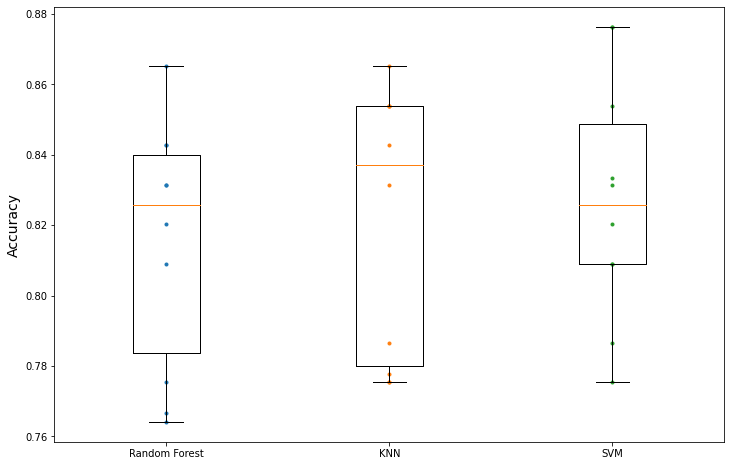

In [39]:
plt.figure(figsize=(12, 8))
plt.plot([1]*10, rand_forest_scores, ".")
plt.plot([2]*10, knn_scores, ".")
plt.plot([3]*10, svm_scores, ".")
plt.boxplot([rand_forest_scores, knn_scores, svm_scores], labels=("Random Forest","KNN", "SVM"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

### Grid search for SVM

In [40]:
param_grid = [
    {'C': [0.5, 1.0, 2.0, 3.0],
     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'gamma': ['scale', 'auto']
    },
]

In [41]:
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=3)

In [42]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.5, gamma=scale, kernel=linear ...............................
[CV] ... C=0.5, gamma=scale, kernel=linear, score=0.804, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=linear ...............................
[CV] ... C=0.5, gamma=scale, kernel=linear, score=0.803, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=linear ...............................
[CV] ... C=0.5, gamma=scale, kernel=linear, score=0.787, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=linear ...............................
[CV] ... C=0.5, gamma=scale, kernel=linear, score=0.753, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=linear ...............................
[CV] ... C=0.5, gamma=scale, kernel=linear, score=0.787, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=poly .................................
[CV] ..... C=0.5, gamma=scale, kernel=poly, score=0.777, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=poly .................................
[CV] ..... C=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.5, gamma=scale, kernel=rbf, score=0.837, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=scale, kernel=sigmoid, score=0.687, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=scale, kernel=sigmoid, score=0.697, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=scale, kernel=sigmoid, score=0.758, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=scale, kernel=sigmoid, score=0.725, total=   0.0s
[CV] C=0.5, gamma=scale, kernel=sigmoid ..............................
[CV] .. C=0.5, gamma=scale, kernel=sigmoid, score=0.702, total=   0.0s
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] .... C=0.5, gamma=auto, kernel=linear, score=0.804, total=   0.0s
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] .

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.5, 1.0, 2.0, 3.0], 'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             verbose=3)

In [43]:
grid_search.best_score_

0.8260435628648548

In [44]:
grid_search.best_params_

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [45]:
final_model = grid_search.best_estimator_

In [46]:
y_train_pred = cross_val_predict(final_model, X_train, y_train, cv=3)

In [47]:
conf_mx = confusion_matrix(y_train, y_train_pred)

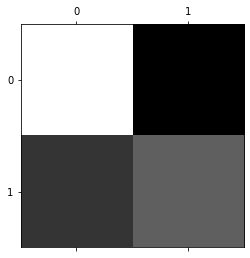

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [49]:
X_test = full_pipeline.fit_transform(test_df)

In [50]:
final_predictions = final_model.predict(X_test)

In [51]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': final_predictions})
output.to_csv('submission.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
